In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import gc

from tabpfn import TabPFNClassifier
from sklearn import preprocessing
from sklearn import impute

import optuna
from optuna.visualization import (
    plot_contour
    , plot_edf
    , plot_intermediate_values
    , plot_optimization_history
    , plot_parallel_coordinate
    , plot_param_importances
    , plot_slice
)

pd.set_option('display.max_columns', None)


import plotly.express as px
import plotly.io as pio
pio.renderers.default = "png"

/home/mavillan/mambaforge/envs/kg/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


***
## loading data

In [2]:
input_path = "../data/raw"

train = pd.read_csv(f"{input_path}/train.csv")
test  = pd.read_csv(f"{input_path}/test.csv")
greeks = pd.read_csv(f"{input_path}/greeks.csv")

train.columns = [col.strip() for col in train.columns]
test.columns = [col.strip() for col in test.columns]

# available features
input_cols = train.columns[1:-1]
categ_cols = ["EJ"]

# we extend train with dummies from greeks
dummies = pd.get_dummies(greeks[["Alpha","Beta","Gamma","Delta"]])
train[dummies.columns] = dummies

# encode of categorical features
encoder = preprocessing.LabelEncoder().fit(train["EJ"])
train["EJ"] = encoder.transform(train["EJ"]).astype(int)
test["EJ"] = encoder.transform(test["EJ"]).astype(int)

display(train)

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,BN,BP,BQ,BR,BZ,CB,CC,CD,CF,CH,CL,CR,CS,CU,CW,DA,DE,DF,DH,DI,DL,DN,DU,DV,DY,EB,EE,EG,EH,EJ,EL,EP,EU,FC,FD,FE,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class,Alpha_A,Alpha_B,Alpha_D,Alpha_G,Beta_A,Beta_B,Beta_C,Gamma_A,Gamma_B,Gamma_E,Gamma_F,Gamma_G,Gamma_H,Gamma_M,Gamma_N,Delta_A,Delta_B,Delta_C,Delta_D
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,4126.58731,22.5984,175.638726,152.707705,823.928241,257.432377,47.223358,0.563481,23.387600,4.851915,0.023482,1.050225,0.069225,13.784111,1.302012,36.205956,69.08340,295.570575,0.238680,0.284232,89.245560,84.31664,29.657104,5.310690,1.74307,23.187704,7.294176,1.987283,1433.166750,0.949104,1,30.879420,78.526968,3.828384,13.394640,10.265073,9028.291921,3.583450,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,5496.92824,19.4205,155.868030,14.754720,51.216883,257.432377,30.284345,0.484710,50.628208,6.085041,0.031442,1.113875,1.117800,28.310953,1.357182,37.476568,70.79836,178.553100,0.238680,0.363489,110.581815,75.74548,37.532000,0.005518,1.74307,17.222328,4.926396,0.858603,1111.287150,0.003042,0,109.125159,95.415086,52.260480,17.175984,0.296850,6785.003474,10.358927,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,5135.78024,26.4825,128.988531,219.320160,482.141594,257.432377,32.563713,0.495852,85.955376,5.376488,0.036218,1.050225,0.700350,39.364743,1.009611,21.459644,70.81970,321.426625,0.238680,0.210441,120.056438,65.46984,28.053464,1.289739,1.74307,36.861352,7.813674,8.146651,1494.076488,0.377208,1,109.125159,78.526968,5.390628,224.207424,8.745201,8338.906181,11.626917,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,4169.67738,23.6577,237.282264,11.050410,661.518640,257.432377,15.201914,0.717882,88.159360,2.347652,0.029054,1.400300,0.636075,41.116960,0.722727,21.530392,47.27586,196.607985,0.238680,0.292431,139.824570,71.57120,24.354856,2.655345,1.74307,52.003884,7.386060,3.813326,15691.552180,0.614484,1,31.674357,78.526968,31.323372,59.301984,7.884336,10965.766040,14.852022,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,5728.73412,24.0108,324.546318,149.717165,6074.859475,257.432377,82.213495,0.536467,72.644264,30.537722,0.025472,1.050225,0.693150,31.724726,0.827550,34.415360,74.06532,200.178160,0.238680,0.207708,97.920120,52.83888,26.019912,1.144902,1.74307,9.064856,7.350720,3.490846,1403.656300,0.164268,1,109.125159,91.994825,51.141336,29.102640,4.274640,16198.049590,13.666727,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,fd3dafe738fd,0.149555,3130.05946,123.763599,9.513984,13.020852,3.499305,0.077343,8.545512,2.804172,4157.68439,21.1860,167.877117,27.287375,365.516874,257.432377,41.368691,0.691257,55.163024,4.780452,0.013930,1.177525,0.698250,40.159779,1.070298,7.030640,21.75904,355.930925,0.238680,0.445479,176.977590,90.91832,27.957928,0.005518,2.41906,32.508604,8.015112,1.354416,495.086300,0.003042,0,51.

In [3]:
imputer = impute.SimpleImputer(strategy="median")
imputer.fit(train[input_cols])
train[input_cols] = imputer.transform(train[input_cols])
test[input_cols] = imputer.transform(test[input_cols])

#scaler = preprocessing.MaxAbsScaler()
#scaler.fit(train[input_cols])
#train[input_cols] = scaler.transform(train[input_cols])
#test[input_cols] = scaler.transform(test[input_cols])

In [4]:
repeated_cv_split = joblib.load("../data/iarc-data-split/repeated_5fold_cv_split_4tuning.pkl")
print(len(repeated_cv_split))

# number of repetitions to use
REPETITIONS = 10

10


***
## training

In [5]:
def balanced_logloss_(y_pred, y_true):
    n0 = np.sum(1-y_true)
    n1 = np.sum(y_true)
    p1 = np.clip(y_pred, 1e-15, 1-1e-15)
    p0 = 1-p1
    log_loss0 = - np.sum((1-y_true) * np.log(p0)) / n0
    log_loss1 = - np.sum(y_true * np.log(p1)) / n1
    return (log_loss0 + log_loss1)/2

#def balanced_logloss(y_pred: np.ndarray, data: lgb.Dataset):
#    y_true = data.get_label()
#    return 'balanced_logloss', balanced_logloss_(y_pred, y_true), False 

In [6]:
pct = train.Class.value_counts(normalize=True)
scale_pos_weight = pct[0]/pct[1]
print("scale_pos_weight:", scale_pos_weight)

cnt = train.Class.value_counts(normalize=False)
neg_bagging_fraction = cnt[1]/cnt[0]
print("neg_bagging_fraction:", neg_bagging_fraction)

scale_pos_weight: 4.712962962962963
neg_bagging_fraction: 0.21218074656188604


In [7]:
DEFAULT_PARAMS = {
    'device':'cpu',
    'seed':2112,
    'no_preprocess_mode':False,   
}

def train_validate(
        dataframe,
        input_cols, 
        model_params,
        repeated_cv_split,
        n_repetitions=REPETITIONS,
        verbose=False,
    ):

    metrics = list()
    model_params = dict(model_params)

    for repeat in range(n_repetitions):
        if verbose:
            print(f"REPEAT NUMBER: {repeat+1}/{n_repetitions}")
        cv_split = repeated_cv_split[f"repeat_{repeat}"]
        n_folds = len(cv_split)
        
        for split in cv_split:
            fold = split["fold"]
            train_idx = split["train_idx"]
            valid_idx = split["valid_idx"]
            if verbose:
                print(f"training model for fold: {fold+1}/{n_folds}")
        
            train_df = dataframe.loc[train_idx,:].reset_index(drop=True)
            valid_df = dataframe.loc[valid_idx,:].reset_index(drop=True)

            clf = TabPFNClassifier(**model_params)
            clf.fit(
                train_df[input_cols].values, 
                train_df["Class"].values, 
                overwrite_warning=True
            )
            y_pred = clf.predict_proba(valid_df[input_cols].values)

            metrics.append( balanced_logloss_(y_pred[:,1], valid_df["Class"].values) )
    
    return np.mean(metrics), np.std(metrics)


def objective(trial):
    _model_params = dict(
        N_ensemble_configurations = trial.suggest_int("N_ensemble_configurations", 4, 48),
        multiclass_decoder = trial.suggest_categorical("multiclass_decoder", ["permutation", ""]),
        feature_shift_decoder = trial.suggest_categorical("feature_shift_decoder", [True, False]),
    )
    model_params = {**DEFAULT_PARAMS, **_model_params}
    
    metric_mean, metric_std = train_validate(
        dataframe = train,
        input_cols = input_cols,
        model_params = model_params,
        repeated_cv_split = repeated_cv_split,
        n_repetitions = REPETITIONS,
        verbose = False,
    )
    
    return metric_mean

In [8]:
%%time

train_validate(
    dataframe = train,
    input_cols = input_cols,
    model_params = dict(N_ensemble_configurations=4, ),
    repeated_cv_split = repeated_cv_split,
    n_repetitions = REPETITIONS,
    verbose = False,
)

Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


CPU times: user 4min 47s, sys: 2.22 s, total: 4min 49s
Wall time: 39 s


(0.36983149081359734, 0.11315270521417865)

In [9]:
do_optimize = True

search_space = {
    'N_ensemble_configurations': list(range(4,49,4)),
    "multiclass_decoder": ["permutation", ""],
    "feature_shift_decoder": [True, False],
}
study = optuna.create_study(
    study_name="iarc-tabpfn",
    direction='minimize',
    storage='sqlite:///iarc-tabpfn.db',
    load_if_exists=True,
    sampler=optuna.samplers.GridSampler(search_space),
)

if do_optimize:
    study.optimize(
        objective, 
        n_trials=10_000, 
        timeout=43200, # 12 hours
        n_jobs=1, 
        gc_after_trial=True,
    ) 

[I 2023-08-08 22:46:28,704] A new study created in RDB with name: iarc-tabpfn


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


[I 2023-08-08 22:49:05,521] Trial 0 finished with value: 0.39235424043967077 and parameters: {'N_ensemble_configurations': 32, 'feature_shift_decoder': True, 'multiclass_decoder': ''}. Best is trial 0 with value: 0.39235424043967077.


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


[I 2023-08-08 22:52:02,870] Trial 1 finished with value: 0.3830388807346 and parameters: {'N_ensemble_configurations': 40, 'feature_shift_decoder': True, 'multiclass_decoder': 'permutation'}. Best is trial 1 with value: 0.3830388807346.


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


[I 2023-08-08 22:52:40,267] Trial 2 finished with value: 0.39269619007030265 and parameters: {'N_ensemble_configurations': 4, 'feature_shift_decoder': True, 'multiclass_decoder': ''}. Best is trial 1 with value: 0.3830388807346.


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


[I 2023-08-08 22:55:37,555] Trial 3 finished with value: 0.39285469150299257 and parameters: {'N_ensemble_configurations': 40, 'feature_shift_decoder': True, 'multiclass_decoder': ''}. Best is trial 1 with value: 0.3830388807346.


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


[I 2023-08-08 22:56:17,595] Trial 4 finished with value: 0.3793298538759977 and parameters: {'N_ensemble_configurations': 24, 'feature_shift_decoder': False, 'multiclass_decoder': 'permutation'}. Best is trial 4 with value: 0.3793298538759977.


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


[I 2023-08-08 22:58:37,255] Trial 5 finished with value: 0.38404552735196335 and parameters: {'N_ensemble_configurations': 28, 'feature_shift_decoder': True, 'multiclass_decoder': 'permutation'}. Best is trial 4 with value: 0.3793298538759977.


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


[I 2023-08-08 22:59:10,593] Trial 6 finished with value: 0.39176687029643475 and parameters: {'N_ensemble_configurations': 12, 'feature_shift_decoder': False, 'multiclass_decoder': ''}. Best is trial 4 with value: 0.3793298538759977.


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


[I 2023-08-08 22:59:44,559] Trial 7 finished with value: 0.39176687029643475 and parameters: {'N_ensemble_configurations': 20, 'feature_shift_decoder': False, 'multiclass_decoder': ''}. Best is trial 4 with value: 0.3793298538759977.


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


[I 2023-08-08 23:00:18,180] Trial 8 finished with value: 0.39176687029643475 and parameters: {'N_ensemble_configurations': 44, 'feature_shift_decoder': False, 'multiclass_decoder': ''}. Best is trial 4 with value: 0.3793298538759977.


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


[I 2023-08-08 23:02:10,979] Trial 9 finished with value: 0.3822663135093645 and parameters: {'N_ensemble_configurations': 24, 'feature_shift_decoder': True, 'multiclass_decoder': 'permutation'}. Best is trial 4 with value: 0.3793298538759977.


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


[I 2023-08-08 23:05:22,283] Trial 10 finished with value: 0.3815979746244389 and parameters: {'N_ensemble_configurations': 44, 'feature_shift_decoder': True, 'multiclass_decoder': 'permutation'}. Best is trial 4 with value: 0.3793298538759977.


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


[I 2023-08-08 23:05:54,811] Trial 11 finished with value: 0.39176687029643475 and parameters: {'N_ensemble_configurations': 8, 'feature_shift_decoder': False, 'multiclass_decoder': ''}. Best is trial 4 with value: 0.3793298538759977.


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


[I 2023-08-08 23:06:33,451] Trial 12 finished with value: 0.3793298538759977 and parameters: {'N_ensemble_configurations': 40, 'feature_shift_decoder': False, 'multiclass_decoder': 'permutation'}. Best is trial 4 with value: 0.3793298538759977.


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


[I 2023-08-08 23:08:14,967] Trial 13 finished with value: 0.39352149848431617 and parameters: {'N_ensemble_configurations': 20, 'feature_shift_decoder': True, 'multiclass_decoder': ''}. Best is trial 4 with value: 0.3793298538759977.


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


[I 2023-08-08 23:08:53,600] Trial 14 finished with value: 0.3793298538759977 and parameters: {'N_ensemble_configurations': 48, 'feature_shift_decoder': False, 'multiclass_decoder': 'permutation'}. Best is trial 4 with value: 0.3793298538759977.


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


[I 2023-08-08 23:10:15,900] Trial 15 finished with value: 0.3946768026996291 and parameters: {'N_ensemble_configurations': 16, 'feature_shift_decoder': True, 'multiclass_decoder': ''}. Best is trial 4 with value: 0.3793298538759977.


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


[I 2023-08-08 23:11:37,771] Trial 16 finished with value: 0.38441116727247765 and parameters: {'N_ensemble_configurations': 16, 'feature_shift_decoder': True, 'multiclass_decoder': 'permutation'}. Best is trial 4 with value: 0.3793298538759977.


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


[I 2023-08-08 23:12:16,576] Trial 17 finished with value: 0.3793298538759977 and parameters: {'N_ensemble_configurations': 16, 'feature_shift_decoder': False, 'multiclass_decoder': 'permutation'}. Best is trial 4 with value: 0.3793298538759977.


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


[I 2023-08-08 23:12:49,371] Trial 18 finished with value: 0.39176687029643475 and parameters: {'N_ensemble_configurations': 40, 'feature_shift_decoder': False, 'multiclass_decoder': ''}. Best is trial 4 with value: 0.3793298538759977.


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


[I 2023-08-08 23:15:05,435] Trial 19 finished with value: 0.39261899965218566 and parameters: {'N_ensemble_configurations': 28, 'feature_shift_decoder': True, 'multiclass_decoder': ''}. Best is trial 4 with value: 0.3793298538759977.


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


[I 2023-08-08 23:15:43,401] Trial 20 finished with value: 0.3793298538759977 and parameters: {'N_ensemble_configurations': 32, 'feature_shift_decoder': False, 'multiclass_decoder': 'permutation'}. Best is trial 4 with value: 0.3793298538759977.


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


[I 2023-08-08 23:16:15,645] Trial 21 finished with value: 0.39176687029643475 and parameters: {'N_ensemble_configurations': 24, 'feature_shift_decoder': False, 'multiclass_decoder': ''}. Best is trial 4 with value: 0.3793298538759977.


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


[I 2023-08-08 23:17:15,967] Trial 22 finished with value: 0.38351107418750374 and parameters: {'N_ensemble_configurations': 12, 'feature_shift_decoder': True, 'multiclass_decoder': 'permutation'}. Best is trial 4 with value: 0.3793298538759977.


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


[I 2023-08-08 23:20:45,405] Trial 23 finished with value: 0.3932007121842169 and parameters: {'N_ensemble_configurations': 48, 'feature_shift_decoder': True, 'multiclass_decoder': ''}. Best is trial 4 with value: 0.3793298538759977.


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


[I 2023-08-08 23:21:17,191] Trial 24 finished with value: 0.39176687029643475 and parameters: {'N_ensemble_configurations': 48, 'feature_shift_decoder': False, 'multiclass_decoder': ''}. Best is trial 4 with value: 0.3793298538759977.


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


[I 2023-08-08 23:23:07,766] Trial 25 finished with value: 0.3929391028997168 and parameters: {'N_ensemble_configurations': 24, 'feature_shift_decoder': True, 'multiclass_decoder': ''}. Best is trial 4 with value: 0.3793298538759977.


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


[I 2023-08-08 23:23:39,241] Trial 26 finished with value: 0.39176687029643475 and parameters: {'N_ensemble_configurations': 32, 'feature_shift_decoder': False, 'multiclass_decoder': ''}. Best is trial 4 with value: 0.3793298538759977.


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


[I 2023-08-08 23:26:26,018] Trial 27 finished with value: 0.3831302773811933 and parameters: {'N_ensemble_configurations': 36, 'feature_shift_decoder': True, 'multiclass_decoder': 'permutation'}. Best is trial 4 with value: 0.3793298538759977.


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


[I 2023-08-08 23:28:04,450] Trial 28 finished with value: 0.3827086281142259 and parameters: {'N_ensemble_configurations': 20, 'feature_shift_decoder': True, 'multiclass_decoder': 'permutation'}. Best is trial 4 with value: 0.3793298538759977.


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


[I 2023-08-08 23:28:42,125] Trial 29 finished with value: 0.3793298538759977 and parameters: {'N_ensemble_configurations': 28, 'feature_shift_decoder': False, 'multiclass_decoder': 'permutation'}. Best is trial 4 with value: 0.3793298538759977.


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


[I 2023-08-08 23:31:27,716] Trial 30 finished with value: 0.3921391382764838 and parameters: {'N_ensemble_configurations': 36, 'feature_shift_decoder': True, 'multiclass_decoder': ''}. Best is trial 4 with value: 0.3793298538759977.


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


[I 2023-08-08 23:32:05,054] Trial 31 finished with value: 0.3793298538759977 and parameters: {'N_ensemble_configurations': 4, 'feature_shift_decoder': False, 'multiclass_decoder': 'permutation'}. Best is trial 4 with value: 0.3793298538759977.


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


[I 2023-08-08 23:32:54,662] Trial 32 finished with value: 0.39615769823763763 and parameters: {'N_ensemble_configurations': 8, 'feature_shift_decoder': True, 'multiclass_decoder': ''}. Best is trial 4 with value: 0.3793298538759977.


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


[I 2023-08-08 23:33:32,497] Trial 33 finished with value: 0.3793298538759977 and parameters: {'N_ensemble_configurations': 20, 'feature_shift_decoder': False, 'multiclass_decoder': 'permutation'}. Best is trial 4 with value: 0.3793298538759977.


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


[I 2023-08-08 23:34:10,502] Trial 34 finished with value: 0.38371038728064055 and parameters: {'N_ensemble_configurations': 4, 'feature_shift_decoder': True, 'multiclass_decoder': 'permutation'}. Best is trial 4 with value: 0.3793298538759977.


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


[I 2023-08-08 23:35:10,490] Trial 35 finished with value: 0.39522181712996657 and parameters: {'N_ensemble_configurations': 12, 'feature_shift_decoder': True, 'multiclass_decoder': ''}. Best is trial 4 with value: 0.3793298538759977.


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


[I 2023-08-08 23:35:48,214] Trial 36 finished with value: 0.3793298538759977 and parameters: {'N_ensemble_configurations': 12, 'feature_shift_decoder': False, 'multiclass_decoder': 'permutation'}. Best is trial 4 with value: 0.3793298538759977.


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


[I 2023-08-08 23:39:18,186] Trial 37 finished with value: 0.38129305997183044 and parameters: {'N_ensemble_configurations': 48, 'feature_shift_decoder': True, 'multiclass_decoder': 'permutation'}. Best is trial 4 with value: 0.3793298538759977.


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


[I 2023-08-08 23:39:50,085] Trial 38 finished with value: 0.39176687029643475 and parameters: {'N_ensemble_configurations': 36, 'feature_shift_decoder': False, 'multiclass_decoder': ''}. Best is trial 4 with value: 0.3793298538759977.


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


[I 2023-08-08 23:40:27,932] Trial 39 finished with value: 0.3793298538759977 and parameters: {'N_ensemble_configurations': 36, 'feature_shift_decoder': False, 'multiclass_decoder': 'permutation'}. Best is trial 4 with value: 0.3793298538759977.


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


[I 2023-08-08 23:41:17,701] Trial 40 finished with value: 0.38819448902186393 and parameters: {'N_ensemble_configurations': 8, 'feature_shift_decoder': True, 'multiclass_decoder': 'permutation'}. Best is trial 4 with value: 0.3793298538759977.


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


[I 2023-08-08 23:41:49,588] Trial 41 finished with value: 0.39176687029643475 and parameters: {'N_ensemble_configurations': 28, 'feature_shift_decoder': False, 'multiclass_decoder': ''}. Best is trial 4 with value: 0.3793298538759977.


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


[I 2023-08-08 23:42:27,654] Trial 42 finished with value: 0.3793298538759977 and parameters: {'N_ensemble_configurations': 8, 'feature_shift_decoder': False, 'multiclass_decoder': 'permutation'}. Best is trial 4 with value: 0.3793298538759977.


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


[I 2023-08-08 23:42:59,866] Trial 43 finished with value: 0.39176687029643475 and parameters: {'N_ensemble_configurations': 4, 'feature_shift_decoder': False, 'multiclass_decoder': ''}. Best is trial 4 with value: 0.3793298538759977.


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


[I 2023-08-08 23:46:09,758] Trial 44 finished with value: 0.39341216692527814 and parameters: {'N_ensemble_configurations': 44, 'feature_shift_decoder': True, 'multiclass_decoder': ''}. Best is trial 4 with value: 0.3793298538759977.


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


[I 2023-08-08 23:46:42,063] Trial 45 finished with value: 0.39176687029643475 and parameters: {'N_ensemble_configurations': 16, 'feature_shift_decoder': False, 'multiclass_decoder': ''}. Best is trial 4 with value: 0.3793298538759977.


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


[I 2023-08-08 23:47:24,589] Trial 46 finished with value: 0.3793298538759977 and parameters: {'N_ensemble_configurations': 44, 'feature_shift_decoder': False, 'multiclass_decoder': 'permutation'}. Best is trial 4 with value: 0.3793298538759977.


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


[I 2023-08-08 23:50:00,680] Trial 47 finished with value: 0.38371446259748276 and parameters: {'N_ensemble_configurations': 32, 'feature_shift_decoder': True, 'multiclass_decoder': 'permutation'}. Best is trial 4 with value: 0.3793298538759977.


In [10]:
study.trials_dataframe().sort_values("value", ascending=True).head(20)

,number,value,datetime_start,datetime_complete,duration,params_N_ensemble_configurations,params_feature_shift_decoder,params_multiclass_decoder,system_attrs_grid_id,system_attrs_search_space,state
36,36,0.379330,2023-08-08 23:35:10.642902,2023-08-08 23:35:48.199455,0 days 00:00:37.556553,12,False,permutation,10,"{'N_ensemble_configurations': [4, 8, 12, 16, 2...",COMPLETE
17,17,0.379330,2023-08-08 23:11:37.920712,2023-08-08 23:12:16.559250,0 days 00:00:38.638538,16,False,permutation,14,"{'N_ensemble_configurations': [4, 8, 12, 16, 2...",COMPLETE
46,46,0.379330,2023-08-08 23:46:42.211609,2023-08-08 23:47:24.569601,0 days 00:00:42.357992,44,False,permutation,42,"{'N_ensemble_configurations': [4, 8, 12, 16, 2...",COMPLETE
14,14,0.379330,2023-08-08 23:08:15.153043,2023-08-08 23:08:53.581239,0 days 00:00:38.428196,48,False,permutation,46,"{'N_ensemble_configurations': [4, 8, 12, 16, 2...",COMPLETE
42,42,0.379330,2023-08-08 23:41:49.736959,2023-08-08 23:42:27.640117,0 days 00:00:37.903158,8,False,permutation,6,"{'N_ensemble_configurations': [4, 8, 12, 16, 2...",COMPLETE
12,12,0.379330,2023-08-08 23:05:54.992647,2023-08-08 23:06:33.436236,0 days 00:00:38.443589,40,False,permutation,38,"{'N_ensemble_configurations': [4, 8, 12, 16, 2...",COMPLETE
39,39,0.379330,2023-08-08 23:39:50.236351,2023-08-08 23:40:27.916374,0 days 00:00:37.680023,36,False,permutation,34,"{'N_ensemble_configurations': [4, 8, 12, 16, 2...",COMPLETE
20,20,0.379330,2023-08-08 23:15:05.594504,2023-08-08 23:15:43.386229,0 days 00:00:37.791725,32,False,permutation,30,"{'N_ensemble_configurations': [4, 8, 12, 16, 2...",COMPLETE
29,29,0.379330,2023-08-08 23:28:04.615075,2023-08-08 23:28:42.110709,0 days 00:00:37.495634,28,False,permutation,26,"{'N_ensemble_configurations': [4, 8, 12, 16, 2...",COMPLETE
31,31,0.379330,2023-08-08 23:31:27.866397,2023-08-08 23:32:05.038926,0 days 00:00:37.172529,4,False,permutation,2,"{'N_ensemble_configurations': [4, 8, 12, 16, 2...",COMPLETE


/home/mavillan/mambaforge/envs/kg/lib/python3.10/site-packages/kaleido/scopes/base.py:188: DeprecationWarning:

setDaemon() is deprecated, set the daemon attribute instead



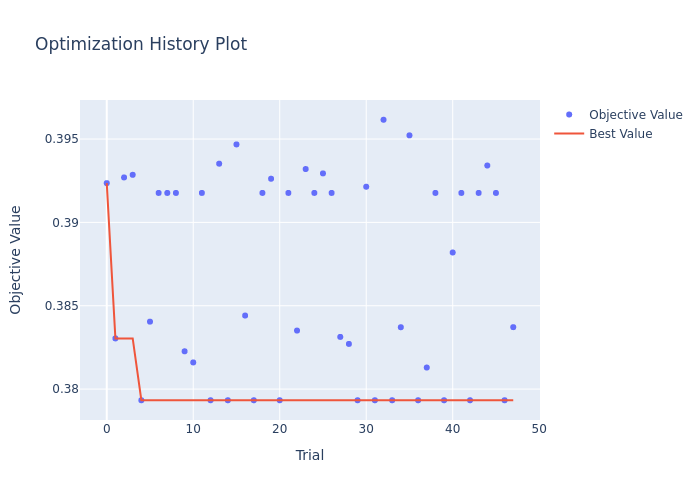

In [11]:
plot_optimization_history(study)

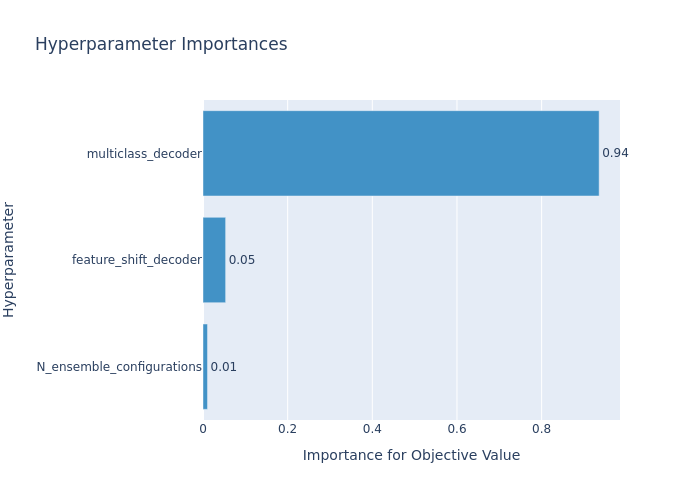

In [12]:
plot_param_importances(study)

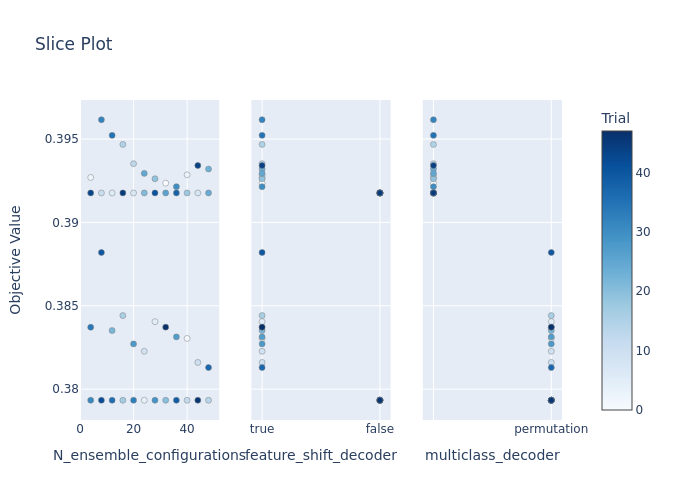

In [13]:
plot_slice(study)

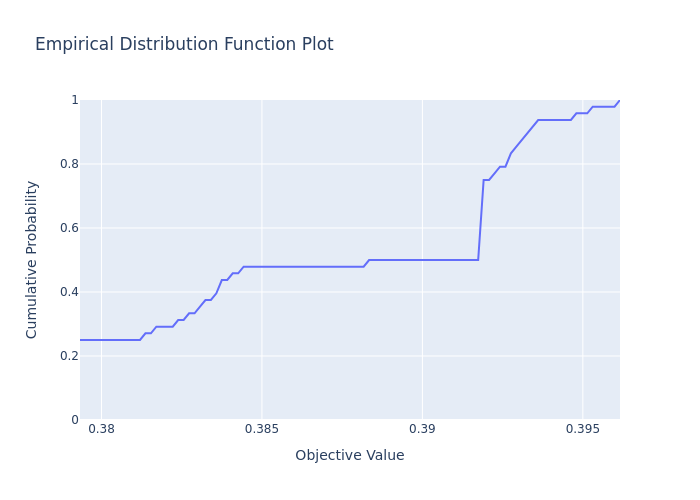

In [14]:
plot_edf(study)

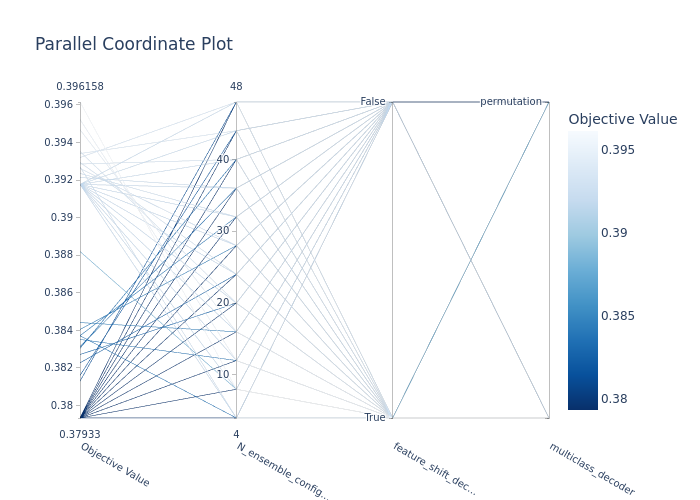

In [15]:
plot_parallel_coordinate(study)

In [16]:
best_params = dict(study.best_params)
best_params = {**DEFAULT_PARAMS, **best_params}
best_params

{'device': 'cpu',
 'seed': 2112,
 'no_preprocess_mode': False,
 'N_ensemble_configurations': 24,
 'feature_shift_decoder': False,
 'multiclass_decoder': 'permutation'}

***